In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
#Importamos todos los modulos de scikit learn
import sklearn.neural_network
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import check_random_state
from sklearn.metrics import f1_score

Carguemos los datos del data set: https://archive.ics.uci.edu/ml/datasets/Relative+location+of+CT+slices+on+axial+axis# \\
F. Graf, H.-P. Kriegel, M. Schubert, S. Poelsterl, A. Cavallaro (2019). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Ludwig-Maximilians-UniversitÃt Munich  

In [2]:
# Carga datos
data = pd.read_csv('slice_localization_data.csv')
data.head
data = data.dropna()
print(np.shape(data))

(53500, 386)


Para obtener 10 clases posibles vamos a reducir las 180 posibildiades de la columna referencia (ubicacion del corte) a 10 unicamente

In [3]:
Y = np.array(data['reference'])
Y = np.rint(Y) 
for i in range(len(Y)):
    if Y[i]<18:
        Y[i]=1
    elif Y[i] <36:
        Y[i]=2
    elif Y[i]<54:
        Y[i]=3
    elif Y[i]<72:
        Y[i]=4
    elif Y[i]<90:
        Y[i]=5
    elif Y[i]<108:
        Y[i]=6
    elif Y[i]<126:
        Y[i]=7
    elif Y[i]<144:
        Y[i]=8
    elif Y[i]<162:
        Y[i]=9
    elif Y[i]<180:
        Y[i]=10

Con el objetivo de que se pueda correr bien todo el codigo se tomaran solo los primeros 4000 datos, para satisfacer todas las restricciones de los datasets

In [4]:
data= data.drop(['patientId','reference'],axis=1)
data = data[:4000]
Y = Y[:4000]

In [5]:
print(np.shape(data), np.shape(Y))

(4000, 384) (4000,)


Ahora si nos ponemos a laborar

In [9]:
x_train, x_test, y_train, y_test = train_test_split(data, Y, train_size=0.5)

scaler = StandardScaler()
X_train = scaler.fit_transform(x_train)
X_test = scaler.transform(x_test)
train_samples = len(X_train)
print(train_samples)

2000


In [11]:
mlp_soft = sklearn.neural_network.MLPClassifier(activation='logistic', hidden_layer_sizes=(4,4,4),max_iter=2500)
mlp_relu = sklearn.neural_network.MLPClassifier(activation='relu', hidden_layer_sizes=(4,4,4),max_iter=2500)
F1_soft_test = []
F1_soft_train = []
F1_relu_test = []
F1_relu_train = []
for i in range(10):
    train_samples_aqui = int(train_samples*((i+1)/10))
    print(train_samples_aqui)
    x_train_aqui = x_train[0:train_samples_aqui]
    y_train_aqui = y_train[0:train_samples_aqui]
    x_test_aqui =  x_test[0:train_samples_aqui] 
    y_test_aqui = y_test[0:train_samples_aqui]
    mlp_soft.fit(x_train_aqui, y_train_aqui)
    mlp_relu.fit(x_train_aqui, y_train_aqui)
    F1_soft_test.append(sklearn.metrics.f1_score(y_test_aqui, mlp_soft.predict(x_test_aqui), average='macro'))
    F1_soft_train.append(sklearn.metrics.f1_score(y_train_aqui, mlp_soft.predict(x_train_aqui), average='macro'))
    F1_relu_test.append(sklearn.metrics.f1_score(y_test_aqui, mlp_relu.predict(x_test_aqui), average='macro'))
    F1_relu_train.append(sklearn.metrics.f1_score(y_train_aqui, mlp_relu.predict(x_train_aqui), average='macro'))

200
400
600
800
1000
1200
1400
1600
1800
2000


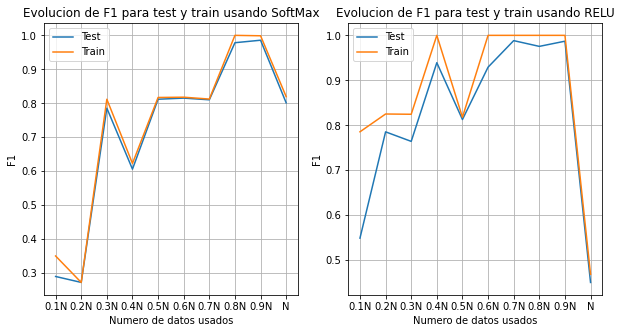

In [17]:
#Graficamos la evolucion de la funcion F1
x = np.linspace(0,10,10)

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.plot(x,F1_soft_test, label='Test')
plt.plot(x,F1_soft_train, label='Train')
plt.title('Evolucion de F1 para test y train usando SoftMax')
plt.xlabel('Numero de datos usados')
plt.ylabel('F1')
my_xticks = ['0.1N','0.2N','0.3N','0.4N','0.5N','0.6N','0.7N','0.8N','0.9N','N']
plt.xticks(x, my_xticks)
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(x,F1_relu_test, label='Test')
plt.plot(x,F1_relu_train, label='Train')
plt.title('Evolucion de F1 para test y train usando RELU')
plt.xlabel('Numero de datos usados')
plt.ylabel('F1')
my_xticks = ['0.1N','0.2N','0.3N','0.4N','0.5N','0.6N','0.7N','0.8N','0.9N','N']
plt.xticks(x, my_xticks)
plt.legend()
plt.grid(True)

plt.show()

Es curioso como al pasar a N datos, baja drasticamente el F1. El valle que se encuentra en 0.4N y 0.5N son tambien particulares Pero se puede concluir que ara 0.8N los resultados son los mejores. 

Realizamos ahora el codigo para ver la variacion del F1 de la red RELU en funcion del parametro alpha

In [18]:
alphas = np.logspace(-4,4,10)
F1_relu_a_test = []
F1_relu_a_train = []
for i in range(10):
    mlp_relu = sklearn.neural_network.MLPClassifier(activation='relu', hidden_layer_sizes=(4,4,4) , alpha=alphas[i] , max_iter=2500)
    mlp_relu.fit(x_train, y_train)
    F1_relu_a_test.append(sklearn.metrics.f1_score(y_test, mlp_relu.predict(x_test), average='macro'))
    F1_relu_a_train.append(sklearn.metrics.f1_score(y_train, mlp_relu.predict(x_train), average='macro'))

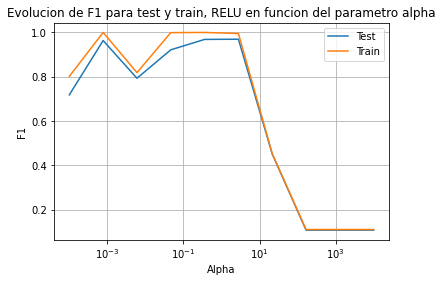

In [21]:
plt.plot(alphas,F1_relu_a_test, label='Test')
plt.plot(alphas,F1_relu_a_train, label='Train')
plt.title('Evolucion de F1 para test y train, RELU en funcion del parametro alpha')
plt.xlabel('Alpha')
plt.xscale("log")
plt.ylabel('F1')
plt.legend()
plt.grid(True)

plt.show()

Podemos ver que es interesante el decaimiento del F1 a partir del $$\alpha = 1$$. La documentacion recomienda alphas grandes para casos en donde la frontera no es clara y es necesaria una frontera gradual. Tiene entonces sentido que los mejores $$\alpha$$ para nosotros no sean muy grandes pero no muy bajos ya que la frontera entre una ubicacion y otra en el cuerpo no es tan clara. Si se hubieran tomado mas clases talvez hubiera sido un mejor F1 con $$\alpha$$ mayores. 